# [NML23] Assignment 2: Machine Learning on Graphs: Hand-crafted Features and Node Embeddings

TAs: [Jinhan Liu](https://people.epfl.ch/jinhan.liu) and [Arun Venkitaraman](https://people.epfl.ch/arun.venkitaraman)

## Students

* Team: `1`
* Students: `Justin Deschenaux`, `Yixuan Xu`

## Rules

> ⚠️ **Read carefully before starting**

**Deadline:** 

**Grading:**
* The integrality of Assignment 2 will be scaled to 100% and will amount to 25% of the overall assignments score.
* The total number of points is **40**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Anything outside shall not be touched, except if otherwise stated.

Theoretical questions shall be answered in the following markdown cell. The first line will be 
> **Your answer here:**

**Submission:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored

* You cannot import any other library than we imported.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations

## Objective

The purpose of this assignment is to explore the usefulness of hand-crafted features and learned features with node2vec in a supervised learning setting applied to the tasks of **node-labelling** and **link-prediction**.

The dataset we will use for this assignment is the American Football dataset, that contains network of American football games between Division IA colleges during regular season Fall 2000. Vertices/nodes in the graph represent teams (identified by their college names) and edges represent regular-season games between the two teams they connect.
(https://networks.skewed.de/net/football#fnref:icon)

In [1]:
# Download the package we will use

from IPython.display import clear_output 
clear_output()

In [2]:
# Download the node2vec package we will use
# Run this cell to kill the current runtime after downloading 'node2vec', so a package version conflict about 'gensim' when using 'node2vec' can be avoided
# Run all again after commenting out this cell completely
"""
import os
from IPython.display import clear_output 
!pip install node2vec
clear_output()
os.kill(os.getpid(), 9) 
"""
None

In [3]:
from node2vec import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%env PYTHONHASHSEED=0
import numpy as np
import pandas as pd
from IPython.display import clear_output 
clear_output()

First of all, we can download the dataset and retrieve the characteristics of the network in the following cells.

In [4]:
# Download the graph dataset named 'football.gml'
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1wVZoiTcB82N1Aoe7m1McmSK3QMM2LJ9D' -O football.gml
clear_output()

In [5]:
# Read the graph dataset
G = nx.read_gml('football.gml')

# Print the number of nodes and edges within the dataset
number_of_nodes = G.number_of_nodes()
print('Number of nodes: {}' .format(number_of_nodes))
number_of_edges = G.number_of_edges()
print('Number of edges: {}' .format(number_of_edges))

# Retrieve the labels of nodes in the dataset
values = nx.get_node_attributes(G, "value")
labels = np.unique([values[node] for node in G.nodes()])
print('The node labels are: {}' .format(labels))

Number of nodes: 115
Number of edges: 613
The node labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [6]:
# Load the nodes with each label into a set of node lists
node_list = {}
node_list = [[n for n, v in values.items() if v == l] for l in labels]

# Load the edges between nodes with same/different labels into lists
edge_list_same = [[(s, d) for (s, d) in G.edges() if s in node_list[l] and d in node_list[l]] for l in labels]
edge_list_same_all = []
for l in labels:  
  edge_list_same_all += edge_list_same[l]
edge_list_diff = [(s, d) for (s, d) in G.edges() if (s, d) not in edge_list_same_all]

# Show the nodes within each class, or teams within each league
print('The teams in each league are:')
for l in labels: print(node_list[l])

The teams in each league are:
['FloridaState', 'NorthCarolinaState', 'Virginia', 'GeorgiaTech', 'Duke', 'NorthCarolina', 'Clemson', 'WakeForest', 'Maryland']
['VirginiaTech', 'BostonCollege', 'WestVirginia', 'Syracuse', 'Pittsburgh', 'Temple', 'Rutgers', 'MiamiFlorida']
['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState', 'Indiana']
['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState']
['EastCarolina', 'Houston', 'Louisville', 'Memphis', 'SouthernMississippi', 'Tulane', 'Army', 'Cincinnati', 'TexasChristian', 'AlabamaBirmingham']
['CentralFlorida', 'Connecticut', 'Navy', 'NotreDame', 'UtahState']
['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralMichigan', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'Marshall']
['BrighamYoung', 'NewMexico', 'SanDiegoState

Now let's visualize dataset, i.e., the graph connectivity of the nodes, and the node labels. 

In [7]:
nx.get_node_attributes(G, "value")

{'BrighamYoung': 7,
 'FloridaState': 0,
 'Iowa': 2,
 'KansasState': 3,
 'NewMexico': 7,
 'TexasTech': 3,
 'PennState': 2,
 'SouthernCalifornia': 8,
 'ArizonaState': 8,
 'SanDiegoState': 7,
 'Baylor': 3,
 'NorthTexas': 10,
 'NorthernIllinois': 6,
 'Northwestern': 2,
 'WesternMichigan': 6,
 'Wisconsin': 2,
 'Wyoming': 7,
 'Auburn': 9,
 'Akron': 6,
 'VirginiaTech': 1,
 'Alabama': 9,
 'UCLA': 8,
 'Arizona': 8,
 'Utah': 7,
 'ArkansasState': 10,
 'NorthCarolinaState': 0,
 'BallState': 6,
 'Florida': 9,
 'BoiseState': 11,
 'BostonCollege': 1,
 'WestVirginia': 1,
 'BowlingGreenState': 6,
 'Michigan': 2,
 'Virginia': 0,
 'Buffalo': 6,
 'Syracuse': 1,
 'CentralFlorida': 5,
 'GeorgiaTech': 0,
 'CentralMichigan': 6,
 'Purdue': 2,
 'Colorado': 3,
 'ColoradoState': 7,
 'Connecticut': 5,
 'EasternMichigan': 6,
 'EastCarolina': 4,
 'Duke': 0,
 'FresnoState': 11,
 'OhioState': 2,
 'Houston': 4,
 'Rice': 11,
 'Idaho': 10,
 'Washington': 8,
 'Kansas': 3,
 'SouthernMethodist': 11,
 'Kent': 6,
 'Pittsburgh

/Users/justindeschenaux/miniconda3/envs/networks_ml/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


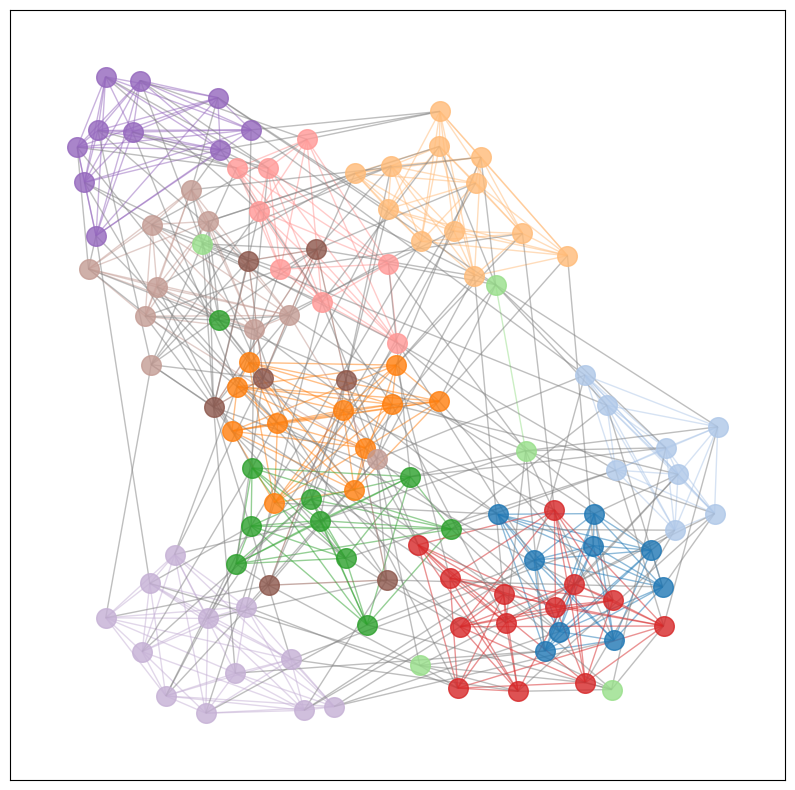

In [8]:
# Visualize the graph structure; nodes and edges within different classes are in different colors
cm = plt.cm.tab20
pos = nx.spring_layout(G, seed=0)
plt.figure(figsize=(10,10)) 

for l in labels:
  nx.draw_networkx_nodes(G, pos, nodelist= node_list[l], node_color=cm(l), node_size=200, alpha=0.8) 
  nx.draw_networkx_edges(G, pos, edgelist = edge_list_same[l], width=1.0, alpha=0.5, edge_color=cm(l))
nx.draw_networkx_edges(G, pos, edgelist = edge_list_diff, width=1.0, alpha=0.5, edge_color="tab:gray")

# **Part A: Node Classification [27 pts]**



In this section, you will perform a node-labelling or classification task. You will do this in two different settings:

(a) Using traditional features of degree, eigenvector centrality,
  betweenness centrality,
  closeness centrality, and the 
  clustering_coefficients, to train a an SVM classifier

(b)  Using node2vec features to train a an SVM classifier

You can use the sklearn library for this task.


## **Question 1: On choice of node features [4pts]**

(a) Can you think of 5 hand-crafted node features (discussed in the theory lectures) that would be the most helpful to the task of node prediction for this dataset? Please motivate your choice in few sentences.

(b) Between the hand-crafted features and node2vec features, which do you think would be better predictors? Please motivate your answer.

**Your answer here:**

(a) We can use the 5 features mentioned in the previous part, that is: 
* Degree: how much of a hub a node is
* Eigenvector, betweeness and closeness centralities: how important a node is in the network. "Important" depends on the exact centrality measure is. It can be related to the number of shortest paths, or how well connected it is to other important nodes.
* Clustering coefficient: how well-connected direct neighbours of a node are.

(b) Looking at the data from the above plot, we can already observe clear cut clusters (light orange and the two purple ones), hence manually-engineered features should provide a good baseline for node classification. However, it is harder to differentiate other groups (eg green, red and dark blue) as they look tightly coupled, hence node2vec might provide additional benefit here since it relies on 2nd order markov chain sampling (as the random walk depends on two previous steps) instead of ad-hoc properties.

## **Question 2: Data Extraction [3 pts]** 


### 2.1  Node Feature Extraction [2 pts]
Extract the 5 traditional/hand-crafted features you chose in the earlier question and form a 5-dimensional feature vector for every node in the following cell. 

In [9]:
def node_feature_extraction(G):
  '''
  INPUT:
  G: the graph

  OUTPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
  '''
  # Node degree
  node_degree = np.array([nx.degree(G)[node] for node in G.nodes()])

  # Betweenness centrality
  betweenness_centrality = np.array([nx.betweenness_centrality(G)[node] for node in G.nodes()])

  # Closeness centrality
  closeness_centrality = np.array([nx.closeness_centrality(G)[node] for node in G.nodes()])

  # Eigenvector centrality
  eigenvector_centrality = np.array([nx.eigenvector_centrality(G)[node] for node in G.nodes()])

  # Clustering coefficient
  clustering_coefficient = np.array([nx.clustering(G)[node] for node in G.nodes()])

  # Combine all features into a feature matrix
  features = np.column_stack([node_degree, betweenness_centrality, closeness_centrality, eigenvector_centrality, clustering_coefficient])

  return features

In [10]:
G.degree()

DegreeView({'BrighamYoung': 12, 'FloridaState': 12, 'Iowa': 12, 'KansasState': 12, 'NewMexico': 11, 'TexasTech': 12, 'PennState': 12, 'SouthernCalifornia': 12, 'ArizonaState': 11, 'SanDiegoState': 11, 'Baylor': 10, 'NorthTexas': 10, 'NorthernIllinois': 10, 'Northwestern': 11, 'WesternMichigan': 10, 'Wisconsin': 12, 'Wyoming': 11, 'Auburn': 11, 'Akron': 11, 'VirginiaTech': 11, 'Alabama': 11, 'UCLA': 11, 'Arizona': 11, 'Utah': 11, 'ArkansasState': 10, 'NorthCarolinaState': 11, 'BallState': 10, 'Florida': 11, 'BoiseState': 9, 'BostonCollege': 11, 'WestVirginia': 11, 'BowlingGreenState': 11, 'Michigan': 11, 'Virginia': 10, 'Buffalo': 11, 'Syracuse': 11, 'CentralFlorida': 8, 'GeorgiaTech': 11, 'CentralMichigan': 11, 'Purdue': 11, 'Colorado': 11, 'ColoradoState': 10, 'Connecticut': 7, 'EasternMichigan': 11, 'EastCarolina': 11, 'Duke': 11, 'FresnoState': 11, 'OhioState': 11, 'Houston': 11, 'Rice': 11, 'Idaho': 9, 'Washington': 11, 'Kansas': 10, 'SouthernMethodist': 12, 'Kent': 10, 'Pittsburgh

### 2.2  Node Target and Label Extraction [1 pts]
Extract the node targets and all their possible labels in the following cell. 

In [11]:
def node_target_extraction(G):
  '''
  INPUT:
  G: the graph

  OUTPUT:
  targets: target vector of dimensions (N, ) (N: number of samples)
  labels: vector of all possible labels for nodes in the graph 
  '''
# Your solution here ###########################################################
  targets = [nx.get_node_attributes(G, "value")[node] for node in G.nodes()]
  labels  = np.unique(list(nx.get_node_attributes(G, "value").values()))
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return targets, labels

Let's implement and test your feature and target extraction modules in the cell below.

In [126]:
features_node = node_feature_extraction(G)
targets_node, labels_node = node_target_extraction(G)

## **Question 3: Classification Module [5 pts]:**

Design a classifier function by integrating modules including:

1. **Data spliting**: Split dataset into train and test sets (50% - 50%). Make sure the data partition is stratified.

2. **Feature selection**: Implement a feature selection preprocessing step before training to use the k highest scored features for the classification task. You might find `SelectKBest` and `f_classif` in `sklearn.feature_selection` helpful.

3. **Normalization**: Normalize the features after feature selection and before training.

4. **Support-vector based classifier**. You might find `svm.SVC` helpful. Please set `class_weight='balanced'`.

5. **Evaluation**: Implement prediction on the test set. Show the performance using weighted f1 score, and display the confusion matrix. You might find `sklearn.metrics.ConfusionMatrixDisplay` helpful.

*** Please set all `random_state=0` and `seed=0` for reproducibility.**

** This function will be used both for node classification and link prediction in the following parts.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

def classifier(features, targets, labels, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=False, hand_crafted=True):
  ''' 
  INPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
  targets: target vector of dimensions (N, ) (N: number of samples)
  labels: vector of all possible labels for nodes in the graph 
  feature_selection: a flag for whether to use feature selction, bool
  num_features: number of features used from feature selesction
  test_size: please set to 0.5 for reproducibility
  seed: please set to 0 for reproducibility
  verbose: print and plot result or not, bool
  
  OUTPUT:
  cm: confusion matrix on the test set
  f1: weighted f1 score on the test set

  ** Please set all of the random_state=seed in following module **
  '''

  # Split the data into training and testing sets, with test_size=0.5
  # Your solution here ###########################################################  
  X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_size, random_state=seed)
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  if feature_selection:
    ## Your solution here ###########################################################
    ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 

    # Define the pipeline steps
    pipeline_steps = [
        ('feature_selection', SelectKBest(f_classif, k=num_features)),
        ('normalisation', StandardScaler()),
        ('classifier', svm.SVC(random_state=seed, class_weight='balanced'))
    ]

    # Create the pipeline
    clf = Pipeline(pipeline_steps)

    # Fit the pipeline to the training data
    clf.fit(X_train, y_train)

    ## Print the scores for individual features.
    if hand_crafted:
      feature_names = ['degree', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'clustering_coefficient']
    else:
       feature_names = [f'feature_{i}' for i in range(features.shape[1])]
    feature_scores = clf.named_steps['feature_selection'].scores_
    feature_indices = np.argsort(-feature_scores)
    if verbose:
      print('Feature scores:')
      for i, score in enumerate(feature_scores[feature_indices]):
          print(f'{i+1}. Feature {feature_names[feature_indices[i]]}: {score:.3f}')
   
    ##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  else:
    ## Your solution here ###########################################################
    ## Build and train the ML model, including normalization and Support Vector Classifier.

    # Define the pipeline steps
    pipeline_steps = [
        ('normalisation', StandardScaler()),
        ('classifier', svm.SVC(random_state=seed, class_weight='balanced'))
    ]

    # Create the pipeline
    clf = Pipeline(pipeline_steps)

    # Fit the pipeline to the training data
    clf.fit(X_train, y_train)

    ##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  # Your solution here ###########################################################
  # Use the model to predict the labels of the test data
  y_pred = clf.predict(X_test)

  # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
  cm = confusion_matrix(y_test, y_pred, labels=labels)
  f1 = f1_score(y_test, y_pred, average='weighted')

  if verbose:
      print(f"Weighted f1 score: {f1}")
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot()

  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return cm, f1

## **Question 4: Node Classification Using Handcrafted Features [4 pts]:**

### 4.1  Node Classification without Feature Selection [2 pt]

Train the classifier without feature selection (using all the 5 features) and show the output.

Weighted f1 score: 0.37850765416688337


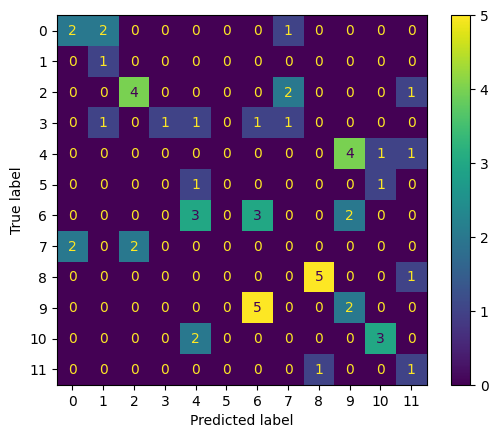

In [14]:
# Your solution here ###########################################################
_, _ =  classifier(features_node, targets_node, labels_node, verbose=True)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Then train the classifier with feature selection with top 3 features and show the output including the feature scores.

Feature scores:
1. Feature clustering_coefficient: 8.056
2. Feature eigenvector_centrality: 7.151
3. Feature closeness_centrality: 2.980
4. Feature degree: 1.435
5. Feature betweenness_centrality: 1.360
Weighted f1 score: 0.30000563443768313


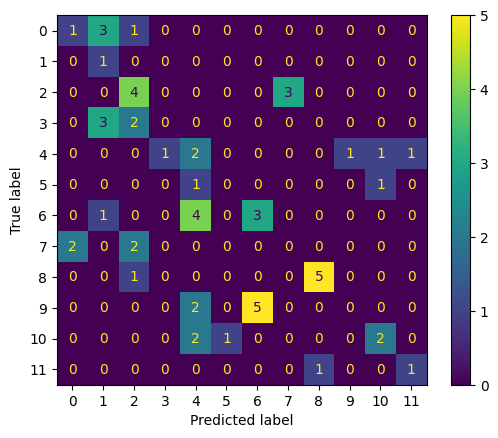

In [15]:
# Your solution here ###########################################################
_, _ =  classifier(features_node, targets_node, labels_node, feature_selection=True, num_features=3, verbose=True)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### 4.2  Find the best number of features selected [1 pt]
With respect to the weighted f1 score, which is the best number of K chosen for the classification performance on the test set? Show the results using different K into a plot and find the best number of K.

In [115]:
def find_best_k(classifier, features, targets, labels, k_range, test_size=0.5, seed=0, plot=False):
  ''' 
  INPUT:
  classifier: the classifier function
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
  targets: target vector of dimensions (N, ) (N: number of samples)
  labels: vector of all possible labels for nodes in the graph 
  k_range: a list of k values to test
  test_size: please set to 0.5 for reproducibility
  seed: please set to 0 for reproducibility
  
  OUTPUT:
  best_k: the best k value
  best_f1: the f1 score for the best k value
  '''

  # Your solution here ###########################################################

  ks = list(k_range)
  f1s = [
    classifier(
      features, 
      targets, 
      labels, 
      feature_selection=True, 
      num_features=k, 
      test_size=test_size, 
      seed=seed)[1] 
    for k in k_range
  ]

  best_f1 = max(f1s)
  best_k = ks[np.argmax(f1s)]

  if plot:
    plt.plot(ks, f1s)
    plt.xlabel("Number of features")
    plt.ylabel("F1 score")
    plt.title("Selecting number of features for best F1-score")
    plt.xticks(ks)
    plt.tight_layout()
    plt.show()
  
  return best_k, best_f1

  #^^^^

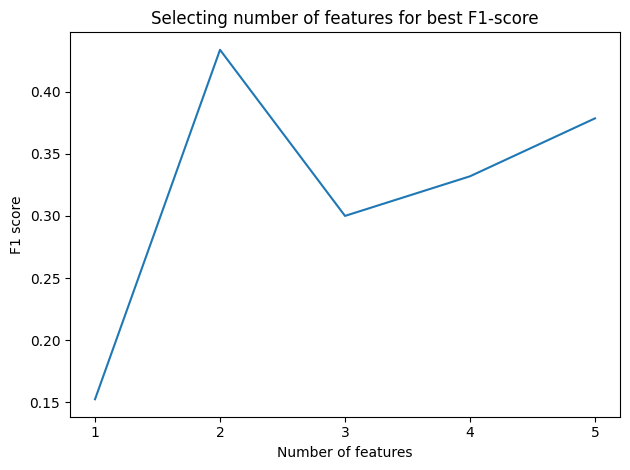

The best K with respect to weighted f1 score is: 2


In [116]:
# Plot the weighted f1 score using different number of best K features in a figure, and print out the best number of K
''' 
  k_best: the best number of K with respect to weighted f1 score on the test set
'''
k_range = range(1, 6)

k_best, _ = find_best_k(classifier, 
                        features_node, 
                        targets_node, 
                        labels_node, k_range, test_size=0.5, seed=0, plot=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print("The best K with respect to weighted f1 score is: {}".format(k_best))

### 4.3  Explanations for the Best Features [1 pt]
What are the best top K features selected in your implementation? Could you please give an possible explanation for why they play important roles in our node classification task? 

**Your answer here:** We obtain the best performance with k=2. The best features are the clustering coefficient and eigenvector centrality.

1. **Clustering coefficient**: As said earlier, we can see visually that nodes with similar labels naturally cluster, i.e. are much more connected to nodes with the same label than with other labels. An hypothesis could be that for each cluster, most nodes have the same clustering coefficient, which is different between clusters. Hence, it would make it easy for the classifier to differentiate based on this value alone
2. **Eigenvector centrality**: This feature measures the importance of a node based on whether its neighbours are important. We can imagine that some clusters are more important than others, and that the graph exhibits some "hierarchy" of nodes starting from a center cluster that is most important. While going further and further from this center cluster, the other clusters would get less and less "important" based on this centrality. This hypothesis combined with the one for the clustering coefficient are appealing. 

One way to test the hypotheses would be to look at the average and standard deviation of clustering coefficient and eigenvector centrality in each class.

## **Question 5: Node2vec features [11 pts]**

### 5.1  Node2Vec Basics [1 pt]

Explain the main components of the Node2vec embedding and discuss in short the relevance of the parameters walk length, p, and q, used in the embedding.



**Your answer here:** The p and q parameter control how fast the random walk escapes the local neighborhood. When sitting at a node $v_{n + 1}$, we have three choices with the following unnormalized probabilities:
* Go back to the previous node $v_n$ (1/p)
* Stay in the neighborhood of $v_n$ (that is a direct neighbour of $v_n$) (1)
* Go away from $v_n$, i.e. to a neighbour of $v_{n + 1}$ at distance 2 from $v_n$ (1/q)

Finally, the walk length measures how much we explore around a node. Too short walks do not give enough information about the neighborhood while too long ones risk to escape the neighborhood (under certain parameters). Once the random walks are generated, they are used to fit a skip-gram model to learn embeddings for nodes by treating them as words of a sentence.

### 5.2 About node2vec parameters [3p]

As you know node2vec has two parameters p and q.
Which configuration of these parameters do you think best suits this task?
low/low, low/high, high/low, or high/high?

Please motivate your answer.


**Your answer here:** Looking at the graph, we observe a strong homophily, i.e. nodes tightly connected have the same label. As seen in the course, random walks closer to DFS are more suited to detect communities. Hence, we expect Node2Vec to work better with p higher than q. Hence we think the best is **p higher, q lower**, the extend of which is to be determined empirically. 

### 5.3  Node2Vec Node Feature Extraction [1 pt]

Extract the node2vec features of nodes using the `node2vec.Node2Vec`.

*** Please set `random_state=0` and `seed=0` for reproducibility.**




In [131]:
def Node2Vec_node_feature_extraction(
    G, 
    num_features=1, 
    p=1.0, 
    q=1.0, 
    walk_length=80,
    per_vertex_num_walks=10,
    skip_gram_window=5,
    seed=0,
    ):
  ''' 
  INPUT:
  G: the graph
  num_features: dimension of node2vec embeddings, int
  p: float
  q: float
  seed: please always set to 0
  
  OUTPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings) 
  '''
  # Your solution here ###########################################################
  np.random.seed(seed)
  n2v = Node2Vec(G, p=p, q=q, seed=seed, dimensions=num_features, quiet=True, walk_length=walk_length, num_walks=per_vertex_num_walks)
  model = n2v.fit(window=skip_gram_window)
  features = model.wv[np.arange(G.number_of_nodes())]
  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return features

### 5.4  Implement node classification using Node2Vec [2 pts]
Let's implement your Node2Vec based classification by setting `num_features=3, p=1.0, q=0.1`

Weighted f1 score: 0.1005473453749316


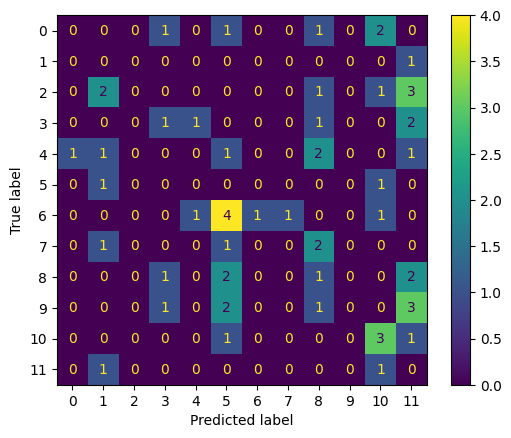

In [19]:
# Implement Node2Vec by setting: 
# Your solution here ###########################################################
w2v_features_1 = Node2Vec_node_feature_extraction(G, 3, 1.0, 0.1)
_, _ =  classifier(w2v_features_1, targets_node, labels_node, verbose=True)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Let's change your parameters to `q=10.0` and implement your results.

Weighted f1 score: 0.07746711537279488


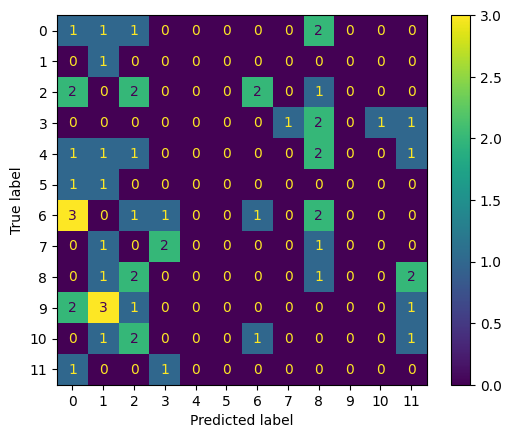

In [20]:
# Implement Node2Vec by changing: 
# q=10.0
# Your solution here ###########################################################
w2v_features_2 = Node2Vec_node_feature_extraction(G, 3, 1.0, 10.0)
_, _ =  classifier(w2v_features_2, targets_node, labels_node, verbose=True)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### 5.5  Parameters in Node2Vec [2 pts]

What difference do you observe in both classifiers? Why do you think this difference exists by changing this parameter?

**Your answer here:** As we have discussed earlier, using a larger value for q makes the random-walks closer to DFS, which is not what we want as our graph exhibits local communities. Hence, the result makes sense, we expect walks with q larger to perform worse, as they behave closer to BFS.

What might be other parameters that we can change in Node2Vec to improve our classification performance? Try to change this parameter and implement in the cell below to achieve a better performance than above.

**Your answer here:** The other parameters of Node2Vec that we can modify are:
* Length of the sequences (random walks) used to fit the skip-gram model
* The number of walk per vertex
* The window size of the skip-gram model

In [142]:
from tqdm import tqdm

def random_search_hyperparameter_tuning(G, n_features, targets, labels, N_EXP=200, SEED=0, classifier=None, mode='node', edge_feature_func=None, operator=None):
    np.random.seed(SEED)
    MIN = 0.01
    MAX = 10
    P_SWEEP = np.random.uniform(MIN, MAX, N_EXP)
    Q_SWEEP = np.random.uniform(MIN, MAX, N_EXP)
    WALK_L_SWEEP = np.random.randint(60, 120, N_EXP)
    PER_V_N_WALK_SWEEP = np.random.randint(6, 15, N_EXP)
    SKIP_GRAM_W_SWEEP = np.random.randint(3, 15, N_EXP)

    best_f1 = best_q = best_p = best_w_l = best_n_walk = best_sg_w = 0

    pbar = tqdm(total=N_EXP, desc="Best f1-score: ???")
    for p, q, walk_len, n_walk, sg_w in zip(P_SWEEP, Q_SWEEP, WALK_L_SWEEP, PER_V_N_WALK_SWEEP, SKIP_GRAM_W_SWEEP):
        sweep_features = Node2Vec_node_feature_extraction(G, n_features, p, q, walk_len, n_walk, sg_w, seed=SEED)

        if mode == 'edge':
            sweep_features = edge_feature_func(sweep_features, operator)

        _, f1 = classifier(sweep_features, targets, labels, verbose=False)
        pbar.update(1)

        if best_f1 < f1:
            pbar.set_description(f"Best f1 score: {f1:.4f}")
            best_f1 = f1
            best_p = p
            best_q = q
            best_w_l = walk_len
            best_n_walk = n_walk
            best_sg_w = sg_w
    pbar.close()

    return best_p, best_q, best_w_l, best_n_walk, best_sg_w, best_f1

In [135]:
# Implement Node2Vec by changing your chosen parameter and try to achieve a better performance
# Your solution here ###########################################################


# Hyperparameters tunning using basic random search
results = random_search_hyperparameter_tuning(G,
                                              n_features=5,
                                              targets=targets_node,
                                              labels=labels_node,
                                              classifier=classifier)


print("### SWEEP RESULTS ###")
print("Best p:",  results[0])
print("Best q:", results[1])
print("Best walk length:", results[2])
print("Best number of walks:", results[3])
print("Best skip-gram window:", results[4])
print("Best f1 score:", results[5])

            
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best f1 score: 0.1984: 100%|██████████| 200/200 [03:28<00:00,  1.04s/it]

### SWEEP RESULTS ###
Best p: 0.6116524615764056
Best q: 1.3293603823880817
Best walk length: 82
Best number of walks: 12
Best skip-gram window: 11
Best f1 score: 0.1983784893267652


### 5.6  Comparing Hand-crafted and Node2Vec Features [2 pts]

Now we can combine the hand-crafted features and node2vec embeddings together. Use the 5 hand-crafted features and 5-dimensional node embeddings. Construct them into 10-dimensional features and implement them into the classifier with top-3 scored features and show the feature scores in the following cell.

*** Please set `seed=0`, `p=1.0` and `q=10.0` for reproducibility.**

Feature scores:
1. Feature feature_4: 8.056
2. Feature feature_3: 7.151
3. Feature feature_2: 2.980
4. Feature feature_8: 2.502
5. Feature feature_0: 1.435
6. Feature feature_6: 1.425
7. Feature feature_1: 1.360
8. Feature feature_5: 0.840
9. Feature feature_9: 0.792
10. Feature feature_7: 0.599
Weighted f1 score: 0.30000563443768313


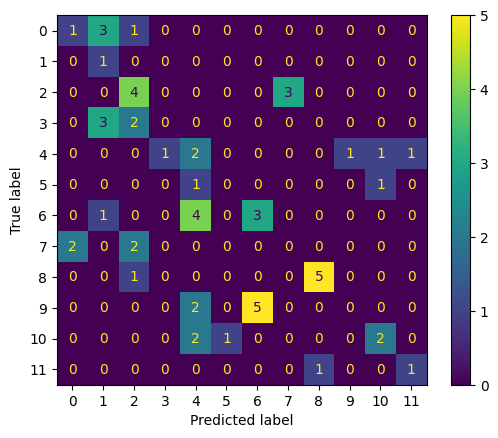

In [23]:
# Implement Node2Vec and combine them with hand-crafted features then use them for classification
# Your solution here ###########################################################
w2v_features =  Node2Vec_node_feature_extraction(G, 5, p=1.0, q=10.0)
all_features = np.concatenate([features_node, w2v_features], axis=1)
_, _ =  classifier(all_features, targets_node, labels_node, feature_selection=True, num_features=3, verbose=True, hand_crafted=False)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

According the results you showed above, which group of features between hand-crafted and Node2Vec are scored better in general? Could you give an explanation for why this group of features are scored higher than the others and are better predictors in the classifier?

**Your answer here:** We see that the **hand-crafted features worked best**, as we achieve the exact same performance and confusion matrix, as the features 0 to 4 are the handcrafted ones. We see three main reasons for such behaviour:
* The graph is relatively **simple**. For most labels, there are more edges between nodes of the same color, than with others
* The graph is too small and simple for Node2Vec: by default, node2vec uses an embedding dimension of 128. Therefore, we expect it is more suited for complicated scenarios. Since the graph is so small, maybe it cannot have enough information to learn a useful representation.
* Bad hyperparameters. Using different hyperparameters than p=1 and q=10, we achieved better in the previous cell (e.g. with p=10, and q=1).

# **Part B: Link Prediction [13 pts]**



In this section, you will perform a link prediction task: We will predict whether or not a link exists between two pairs of nodes, with the entries of the adjancency matrix being the link values to predict (0 or 1). We will consider both handcrafted and node2vec features to train an SVM classifier.

As before you can use the sklearn library for this task.


## **Question 6: Data Extraction [4 pts]**


### 6.1  Operators on Node Features [2 pts]

In absence of specific edge features, a typical approach is to use an operator to combine the node features corresponding to a given edge to form a combined edge feature. That is to arrive at features $f_{ij}$, node features $f_i$ and $f_j$ are used together.

In addition to the `average_operator` below, you should come up with three more different ways of doing this. Each of the proposed ways should be implemented in the cell below.

**You answer here:** We decided to use the min, max and sum operators, as they are commonly used in the GNN literature.


In [24]:
def average_operator(x, y):
  ''' 
  INPUT:
  x, y: pair of node features, each with dimension (D, ) (D: dimension of features) 
  
  OUTPUT:
  edge features by the operation on node features, with dimension (D, )
  '''
  return (x + y) / 2

# Your solution here ###########################################################
def min_operator(x, y):
  return np.minimum(x, y)

def max_operator(x, y):
  return np.maximum(x, y)

def sum_operator(x, y):
  return x + y
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### 6.2  Edge Feature, Target and Label Extraction [2 pts]

Write a code for

(a) Extracting the edge features

(b) extracting the edge target s

In [25]:
def edge_feature_extraction(features_node, operator):
    '''
    INPUT:
    features_node: node feature matrix of dimensions (N, D) (N: number of samples; D: dimension of features)
    operator: operator computing pair of node features, function defined above

    OUTPUT:
    features_edge: edge feature matrix of dimensions (N, D) (N: number of edges assuming an undirected graph; D: dimension of features)
    '''
    N, D = features_node.shape

    # Expanding dimensions of features_node to (N, 1, D) and (1, N, D) for broadcasting
    features_node_expanded1 = np.expand_dims(features_node, axis=1)
    features_node_expanded2 = np.expand_dims(features_node, axis=0)

    # Broadcasting and applying the operator
    features_edge = operator(features_node_expanded1, features_node_expanded2)

    # Create a mask to exclude self-loops (diagonal elements) and lower triangular elements
    mask = np.triu(np.ones((N, N), dtype=bool), k=1)

    # Apply the mask to features_edge
    features_edge = features_edge[mask]

    # assert features_edge.shape == (N * (N - 1) // 2, D)

    # Reshaping the result to the desired shape ((N * (N - 1) // 2), D)
    features_edge = features_edge.reshape((N * (N - 1) // 2), D)

    return features_edge
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [26]:
def edge_target_extraction(G):
  ''' 
  INPUT:
  G: the graph
  
  OUTPUT:
  targets: target vector of dimensions (N, ) (N: number of samples), with values of {0, 1}
  labels: vector of all possible labels for nodes in the graph 
  '''
  # 
  # Your solution here ###########################################################

  adj_matrix = nx.adjacency_matrix(G).toarray()

  # Get the number of nodes
  N = adj_matrix.shape[0]

  # Get the upper triangular part of the adjacency matrix without the diagonal
  mask = np.triu(np.ones((N, N), dtype=bool), k=1)
  
  # Apply the mask to the adjacency matrix
  adj_matrix_upper_triangular = adj_matrix[mask]

  # Reshape the upper triangular part of the adjacency matrix to a target vector
  targets = adj_matrix_upper_triangular.reshape(N * (N - 1) // 2)

  # Labels are indicator for whether the edge is present or not, thus is either 0 or 1
  labels  = np.unique(targets)

  return targets, labels

Let's implement and test your feature and target extraction modules in the cell below. 

*** You can implement the following section using the operator you prefer, while please use the same operator for both hand-crafted and Node2Vec features in the following section.**

In [141]:
# Extract your edge-level features, targets and labels. You can replace `average_operator` with others.
P71_OPERATOR = average_operator
features_edge = edge_feature_extraction(features_node, P71_OPERATOR)
targets_edge, labels_edge = edge_target_extraction(G)
clear_output()

## **Question 7: Link prediction Implementions [9 pts]**

### 7.1  Link Prediction Implementation [5 pts]

Use the method of choice to compute edge-features for the given dataset. Then, train a link predictor, compute the confusion matrix and weighted f1 and ROC AUC scores as before. As before repeat the experiment for the case of node2vec parameter set to values 1 and 10. You may use the itertools library to help you with the feature fusion.

First let's train the classifier based on handcrafted node features without feature selection (using all the 5 features) and show the output.

Weighted f1 score: 0.7377977061271207


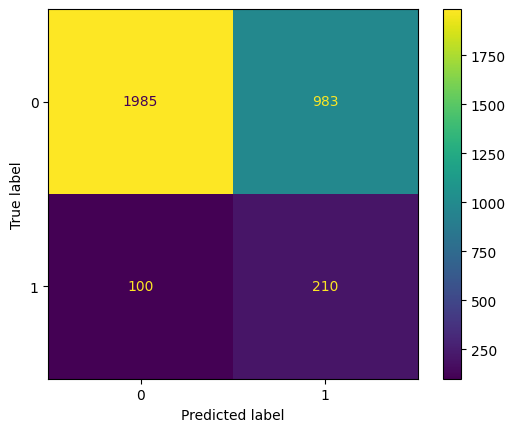

In [28]:
# Your solution here ###########################################################
_, _ =  classifier(features_edge, targets_edge, labels_edge, verbose=True)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Then let's train the classifier based on handcrafted node features with feature selection and show the output.

Best k: 3
Feature scores:
1. Feature degree: 3.970
2. Feature closeness_centrality: 1.533
3. Feature betweenness_centrality: 1.453
4. Feature eigenvector_centrality: 0.993
5. Feature clustering_coefficient: 0.000
Weighted f1 score: 0.7573136556141138


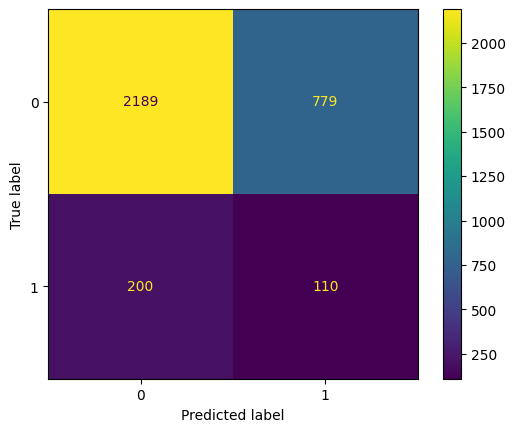

In [29]:
# Your solution here ###########################################################

k_best, _ = find_best_k(classifier, 
                        features_edge, 
                        targets_edge, 
                        labels_edge, k_range, test_size=0.5, seed=0)

print("Best k:", k_best)

_, _ =  classifier(features_edge, targets_edge, labels_edge, feature_selection=True, num_features=k_best, verbose=True)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Train the classifier based on Node2Vec features with `num_features=3, p=1.0, q=0.1` and show the output.

Weighted f1 score: 0.5441697790819755


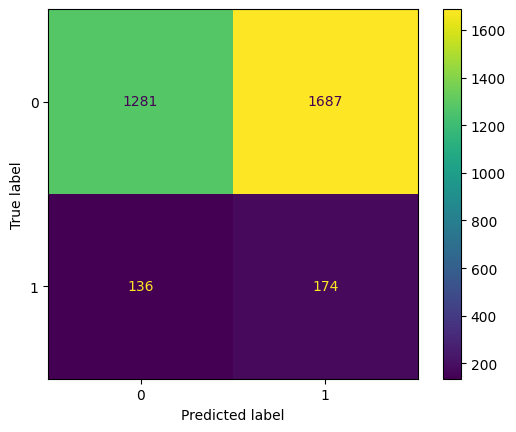

In [30]:
# Your solution here ###########################################################
features_edge = edge_feature_extraction(Node2Vec_node_feature_extraction(G, 3, 1.0, 0.1), 
                                        P71_OPERATOR)

_, _ =  classifier(features_edge, targets_edge, labels_edge, feature_selection=False, verbose=True, hand_crafted=False)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Train the classifier based on Node2Vec features change the parameter to `q=10.0` and show the output.

Weighted f1 score: 0.6042501956911224


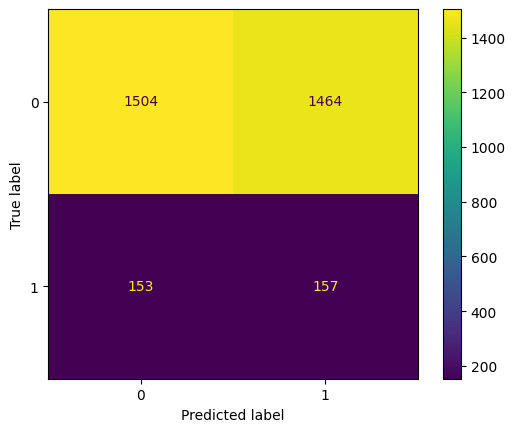

In [31]:
# Your solution here ###########################################################
features_edge = edge_feature_extraction(Node2Vec_node_feature_extraction(G, 3, 1.0, 10.0), 
                                        P71_OPERATOR)

_, _ =  classifier(features_edge, targets_edge, labels_edge, feature_selection=False, verbose=True, hand_crafted=False)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Implement the same change of parameter you chose as it is in **Question 4.4** and show the output.

In [151]:
random_search_hyperparameter_tuning(G,
                                    n_features=3,
                                    targets=targets_edge,
                                    labels=labels_edge,
                                    classifier=classifier,
                                    mode='edge',
                                    edge_feature_func=edge_feature_extraction,
                                    operator=min_operator)

Best f1 score: 0.7364: 100%|██████████| 200/200 [07:23<00:00,  2.22s/it]


(7.744594557447824, 2.1409866539011446, 119, 9, 9, 0.7363995830584822)

In [149]:
# Hyperparameters tunning using basic random search
results = random_search_hyperparameter_tuning(G,
                                              n_features=3,
                                              targets=targets_edge,
                                              labels=labels_edge,
                                              classifier=classifier,
                                              mode='edge',
                                              edge_feature_func=edge_feature_extraction,
                                              operator=P71_OPERATOR)

Best f1 score: 0.7288: 100%|██████████| 200/200 [07:24<00:00,  2.22s/it]


In [150]:
print("### SWEEP RESULTS ###")
print("Best p:",  results[0])
print("Best q:", results[1])
print("Best walk length:", results[2])
print("Best number of walks:", results[3])
print("Best skip-gram window:", results[4])
print("Best f1 score:", results[5])

### SWEEP RESULTS ###
Best p: 7.30260571861634
Best q: 9.041403485080568
Best walk length: 101
Best number of walks: 11
Best skip-gram window: 9
Best f1 score: 0.7288080348661639


Weighted f1 score: 0.7288080348661639


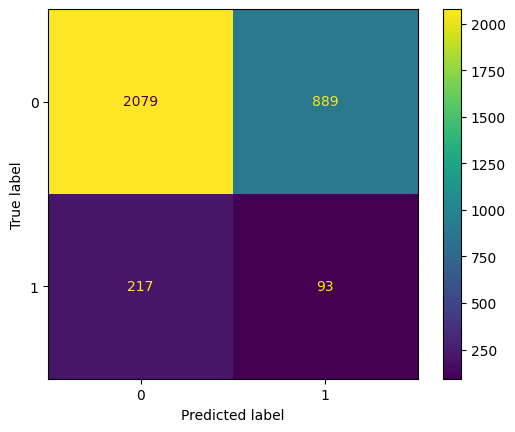

In [152]:
# Hyperparameters are chosen based on the results from the node classification task

features_edge = edge_feature_extraction(
    Node2Vec_node_feature_extraction(
        G, 
        num_features=3, 
        p=results[0], 
        q=results[1], 
        walk_length=results[2], 
        per_vertex_num_walks=results[3], 
        skip_gram_window=results[4],
    ),
    P71_OPERATOR)
_, _ =  classifier(features_edge, targets_edge, labels_edge, feature_selection=False, verbose=True, hand_crafted=False)

Weighted f1 score: 0.7552989336556185


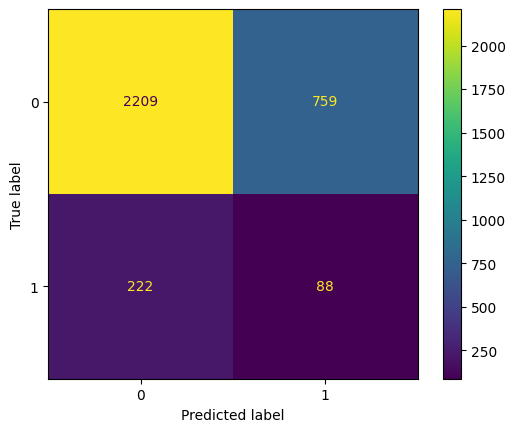

In [32]:
# Hyperparameters are chosen based on the results from the node classification task

features_edge = edge_feature_extraction(
    Node2Vec_node_feature_extraction(
        G, 
        num_features=3, 
        p=0.6116, 
        q=1.3293, 
        walk_length=82, 
        per_vertex_num_walks=12, 
        skip_gram_window=11,
    ),
    P71_OPERATOR)
_, _ =  classifier(features_edge, targets_edge, labels_edge, feature_selection=False, verbose=True, hand_crafted=False)


Similar with **Question 4.5**, use the 5 hand-crafted features and 5-dimensional node embeddings to construct 10-dimensional features and implement them into the classifier with top-3 scored features and show the feature scores in the following cell.

*** Please set `seed=0`, `p=1.0` and `q=10.0` for reproducibility.**

Feature scores:
1. Feature feature_0: 3.970
2. Feature feature_2: 1.533
3. Feature feature_1: 1.453
4. Feature feature_3: 0.993
5. Feature feature_7: 0.349
6. Feature feature_8: 0.326
7. Feature feature_6: 0.237
8. Feature feature_5: 0.044
9. Feature feature_9: 0.004
10. Feature feature_4: 0.000
Weighted f1 score: 0.7573136556141138


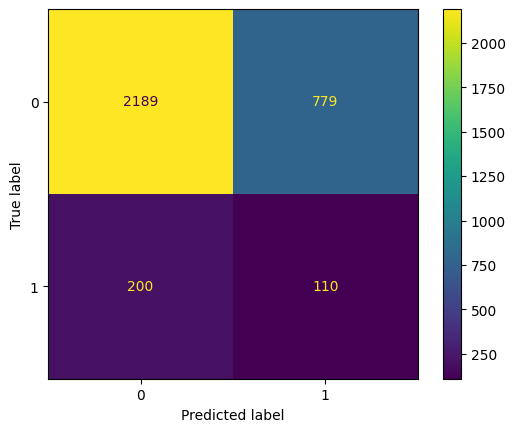

In [33]:
# Implement Node2Vec and combine them with hand-crafted features then use them for classification
# Your solution here ###########################################################

w2v_features =  edge_feature_extraction(Node2Vec_node_feature_extraction(G, 5, p=1.0, q=10.0), P71_OPERATOR)
hc_features = edge_feature_extraction(features_node, P71_OPERATOR)

all_features = np.concatenate([hc_features, w2v_features], axis=1)

_, _ =  classifier(all_features, targets_edge, labels_edge, feature_selection=True, num_features=3, verbose=True, hand_crafted=False)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

According the results you showed above, which group of features between hand-crafted and Node2Vec are scored better in general? Could you give an explanation for why this group of features are scored higher than the others and are better predictors in the classifier?

**Your answer here:** Looking at the scores above, we see that once again, handcrafted features worked best for edge prediction, although we managed to get a similar weighted F1 score using the best hyperparameters found in the node prediction task. Nonetheless, looking at the feature scores, we see that the handcrafted ones are better at predicting the target (Index 0 to 4 are handcrafted, 5 to 9 are from Node2Vec).

As noted in the first part of the homework, we observed that nodes with similar labels tend to be well-connected, as opposed to nodes of different classes. Therefore, the edge classification task is very correlated with the node classification task. Consequently, features that worked well for node classification tasks should also work well for edge classification, hence the average operator makes sense here. 

In the edge classification taks, Node2Vec has the ability to achieve competitive results compared to handcrafted features. However, it requires more hyper-parameter tuning and the features are less interpretable than the handcrafted ones, hence we conclude the handcrafted features are better.

One surprising fact is that we obtain better performance on the edge classification with hyper-parameters found using random search on the original node classification tasks (than when tuned for edge classification directly). As noted earlier, both tasks are correlated since the edge density looks higher inside of a class than with the other classes. We suspect the operator might be interacting negatively with the features learned by Node2Vec.

### 7.2  Link Prediction Observations [4 pt]

Based on your observations on the implementations, among the implementations above using a single group of either hand-crafted and Node2Vec features, which one achieves better performance in general? How do the parameters in Node2Vec influence the classfication performance. 

By combining these features together, which group is scored higher during feature selection? Do and how do the operators on the node-level features influence the classification performance?

**Your answer here**: For the tasks above, handcrafted features achieve better performance in general. One can tune many parameters for Node2Vec and most combinations yield poor performance. Since we tried many values during the hyperparameter sweep, we believe our final Node2Vec features might be overfitted to the test set. We found that the most important parameters were $p$ and $q$. The other ones do play a role in the final performance, but the effect is less pronounced.

One big surprise we had is that using `min_operator` to create the edge features, the `eigenvector_centrality` alone outperforms all combinations we tried. This reinforces our belief that handcrafted features are superior for the simple problem in this assignment


For the sake of completeness, we ran an experiment combining all possible features, the handcrafted and word2vec ones. We also added an additional operator (that you can find below) that measures the dissimilarity between node features. Using all features, the weighted F1-score is not out best result, but we still see that the best edge features are obtained by aggregating handcrafted node features. While the new operator `abs_diff_operator` has large score during the feature selection process, it does not beat the aggregated `eigenvector_centrality` with the `min_operator` with respect to the weighted F1-score (see the next three cells).

We are not sure why the `min_operator` is so much better though.

In [42]:
def abs_diff_operator(x, y):
    return np.abs(x - y)

Best k: 5
Feature scores:
1. Feature feature_23: 158.883
2. Feature feature_13: 53.772
3. Feature feature_24: 47.228
4. Feature feature_18: 30.124
5. Feature feature_19: 15.670
6. Feature feature_14: 11.644
7. Feature feature_22: 10.068
8. Feature feature_12: 7.155
9. Feature feature_10: 6.134
10. Feature feature_20: 5.454
11. Feature feature_0: 3.970
12. Feature feature_5: 3.970
13. Feature feature_11: 2.491
14. Feature feature_7: 1.533
15. Feature feature_2: 1.533
16. Feature feature_1: 1.453
17. Feature feature_6: 1.453
18. Feature feature_37: 1.253
19. Feature feature_3: 0.993
20. Feature feature_8: 0.993
21. Feature feature_31: 0.574
22. Feature feature_35: 0.513
23. Feature feature_16: 0.482
24. Feature feature_26: 0.393
25. Feature feature_29: 0.393
26. Feature feature_17: 0.351
27. Feature feature_33: 0.340
28. Feature feature_27: 0.282
29. Feature feature_30: 0.282
30. Feature feature_34: 0.228
31. Feature feature_32: 0.135
32. Feature feature_21: 0.126
33. Feature feature_38:

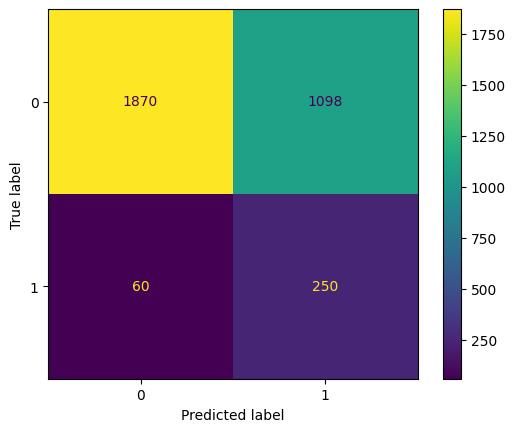

In [46]:
OPERATORS = [average_operator, sum_operator, min_operator, max_operator, abs_diff_operator]

hc_features = [edge_feature_extraction(features_node, op) for op in OPERATORS]
n2v_node_features = Node2Vec_node_feature_extraction(
        G, 
        num_features=3, 
        p=0.6116, 
        q=1.3293, 
        walk_length=82, 
        per_vertex_num_walks=12, 
        skip_gram_window=11,
    )
n2v_edge_features = [edge_feature_extraction(n2v_node_features, op) for op in OPERATORS]

all_features = np.concatenate(hc_features + n2v_edge_features, axis=1)

k_best, _ = find_best_k(classifier, 
                        all_features, 
                        targets_edge, 
                        labels_edge, k_range, test_size=0.5, seed=0)

print("Best k:", k_best)

"""
0-4:    average hand crafted
5-9:    sum handcrafted
10-14:  min handcrafted
15-19:  max handcrafted
20-24:  diff handcrafted
------
25-29:  average Node2Vec
30-34:  sum Node2Vec
35-39:  min Node2Vec
40-44:  max Node2Vec
45-49:  diff Node2Vec
"""

_, _ =  classifier(
    all_features, 
    targets_edge, 
    labels_edge, 
    feature_selection=True, 
    num_features=k_best, 
    verbose=True,
    hand_crafted=False
    )

Feature scores:
1. Feature eigenvector_centrality: 53.772
2. Feature clustering_coefficient: 11.644
3. Feature closeness_centrality: 7.155
4. Feature degree: 6.134
5. Feature betweenness_centrality: 2.491
Weighted f1 score: 0.8302912480859157


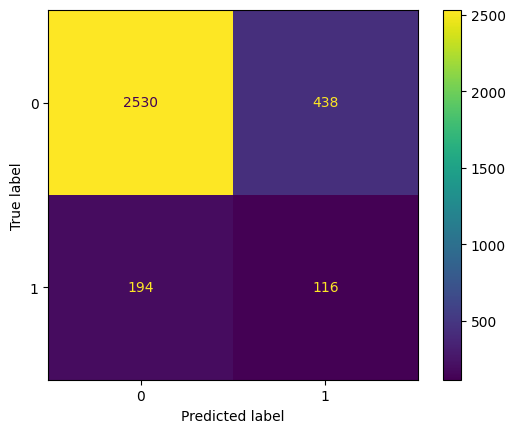

In [49]:
hc_features = edge_feature_extraction(features_node, min_operator)

_, _ =  classifier(
    hc_features, 
    targets_edge, 
    labels_edge, 
    feature_selection=True, 
    num_features=1, 
    verbose=True,
    hand_crafted=True
    )